1. Setup and Load Data

1.1 Install Dependencies and Setup

In [59]:
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import torchvision.models.segmentation
import torch
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import scipy.io
from sklearn.model_selection import train_test_split
import random
from torchviz import make_dot
import torch.optim as optim
from torchsummary import summary

# Set the device to use
# CUDA refers to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 300
batch_size = 128

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# If you are on CoLab and successfully using the GPU, this print should
#   contain "cuda" in it
print(str(device))
assert('cuda' in str(device))  # comment out this assert if you are not using a GPU

torch.cuda.empty_cache()

cuda:0


Load Data

In [60]:
import tqdm

os.chdir('../HMEI2023-bxliu/')

image_list = []
theta_list = []

image_directory = 'image_5by400'
value_directory = 'value_5by400/'

# iterate over files in
# that directory
for filename in tqdm.tqdm(os.listdir(image_directory)):
    # print(filename)
    f = os.path.join(image_directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        # color
        # image = Image.open(f)
        # data = np.asarray(image)

        # gray scale
        data = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2GRAY)
        data = cv2.resize(data, (128,128), interpolation=cv2.INTER_CUBIC)
        data = np.expand_dims(data, axis=2)

        matfile = value_directory + filename[:len(filename) - 4] + '.mat'
        mat = scipy.io.loadmat(matfile)
        image_list.append(data)
        theta_list.append(mat['th0'][0])

print(image_list[0].shape)
print(theta_list[0])

theta_list = np.asarray(theta_list)
image_list = np.asarray(image_list)

image_list = np.moveaxis(image_list, -1, 1)
theta_list = np.moveaxis(theta_list, -1, 1)

print(image_list.shape)

image_list = torch.tensor(image_list).float()

theta_list = torch.tensor(theta_list)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:05<00:00, 384.78it/s]


(128, 128, 1)
[5.e+05 5.e-01 5.e+03]
(2000, 1, 128, 128)


In [61]:
# normalize data:

# images
imean = torch.std(image_list, dim=0)
istd = torch.mean(image_list, dim=0)
# image_tensor = torch.div(torch.sub(image_list, imean), istd)
image_tensor = torch.div(image_list, 255).float()
print(image_tensor)

# theta
tmean = torch.std(theta_list, dim=0)
tstd = torch.mean(theta_list, dim=0)
theta_tensor = torch.div(torch.sub(theta_list, tmean), tstd).float()
# theta_tensor = theta_list.float()
print(theta_tensor)

tensor([[[[0.3333, 0.3373, 0.2824,  ..., 0.2667, 0.5843, 0.5529],
          [0.3176, 0.3255, 0.2471,  ..., 0.2471, 0.5882, 0.5529],
          [0.4902, 0.4784, 0.6000,  ..., 0.4588, 0.5451, 0.5373],
          ...,
          [0.5373, 0.5451, 0.4745,  ..., 0.5529, 0.2510, 0.2824],
          [0.4745, 0.4667, 0.5529,  ..., 0.5843, 0.6000, 0.6000],
          [0.4745, 0.4667, 0.5529,  ..., 0.5843, 0.6000, 0.6000]]],


        [[[0.4588, 0.4549, 0.5059,  ..., 0.4745, 0.6314, 0.6157],
          [0.4667, 0.4627, 0.5255,  ..., 0.4824, 0.6353, 0.6196],
          [0.3804, 0.3882, 0.3137,  ..., 0.3961, 0.5882, 0.5686],
          ...,
          [0.4275, 0.4627, 0.1255,  ..., 0.6980, 0.3451, 0.3804],
          [0.5373, 0.5451, 0.4745,  ..., 0.6824, 0.4157, 0.4431],
          [0.5333, 0.5412, 0.4706,  ..., 0.6784, 0.4118, 0.4353]]],


        [[[0.2824, 0.2667, 0.4118,  ..., 0.4745, 0.5098, 0.5059],
          [0.2745, 0.2588, 0.4078,  ..., 0.4588, 0.5098, 0.5059],
          [0.3647, 0.3569, 0.4431,  ..

In [62]:
full_dataset = TensorDataset(image_tensor, theta_tensor)

train, val, test = torch.utils.data.random_split(full_dataset, [0.75, 0.125, 0.125])
train_loader = DataLoader(train, batch_size=21, shuffle=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=2, shuffle=False)

In [63]:
print(train_loader)
print(val_loader)
print(test_loader)

In [64]:
# image_train, image_test, theta_train, theta_test = train_test_split(image_tensor, theta_tensor)

In [65]:
# print(len(image_train))
# print(len(image_test))

In [66]:
# train_dataset = TensorDataset(image_train, theta_train)
# print(train_dataset)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# print(train_loader)

# test_dataset = TensorDataset(image_test, theta_test)
# print(test_dataset)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# print(test_loader)

Make Network

In [67]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2) 
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 5, padding=2) 
        self.pool3 = nn.MaxPool2d(2, 2)

        self.size_linear = 128*16*16
        self.fc1 = nn.Linear(self.size_linear, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)


    def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x))) 
            x = self.pool2(F.relu(self.conv2(x))) 
            x = self.pool3(F.relu(self.conv3(x)))
            x = x.view(-1, self.size_linear) # this flattens x into a 1D vector
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x)) 
            x = self.fc3(x)
            return x

In [68]:
##ASSERT: checks if CNN has the correct output shape
with torch.no_grad():  # tells PyTorch not to track gradients here
    # test_data is 100 random images, 1 channel, 128-by-128
    test_data = torch.rand(100,1,128,128)
    test_net = ConvNet()
    out = test_net.forward(test_data)
    # the output should have size (100,3)
    print(out)
    print(out.size())
    assert(out.size()==(100,3))

    print(out[0][0])

tensor([[0.0612, 0.0640, 0.0600],
        [0.0623, 0.0662, 0.0593],
        [0.0622, 0.0661, 0.0586],
        [0.0607, 0.0657, 0.0596],
        [0.0610, 0.0666, 0.0586],
        [0.0614, 0.0664, 0.0583],
        [0.0611, 0.0658, 0.0588],
        [0.0617, 0.0665, 0.0586],
        [0.0614, 0.0641, 0.0607],
        [0.0606, 0.0659, 0.0594],
        [0.0612, 0.0634, 0.0593],
        [0.0612, 0.0649, 0.0597],
        [0.0621, 0.0632, 0.0621],
        [0.0603, 0.0668, 0.0589],
        [0.0601, 0.0651, 0.0592],
        [0.0617, 0.0651, 0.0593],
        [0.0615, 0.0656, 0.0587],
        [0.0616, 0.0670, 0.0584],
        [0.0623, 0.0644, 0.0599],
        [0.0605, 0.0661, 0.0606],
        [0.0610, 0.0651, 0.0591],
        [0.0605, 0.0667, 0.0592],
        [0.0611, 0.0649, 0.0598],
        [0.0596, 0.0647, 0.0594],
        [0.0600, 0.0659, 0.0595],
        [0.0619, 0.0651, 0.0584],
        [0.0624, 0.0644, 0.0595],
        [0.0615, 0.0639, 0.0611],
        [0.0605, 0.0662, 0.0584],
        [0.061

Make trainer for training network

In [69]:
class Trainer():
    def __init__(self,net=None,optim=None,loss_function=None, train_loader=None, val_loader=None):
        self.net = net
        self.optim = optim
        self.loss_function = loss_function
        self.train_loader = train_loader
        self.val_loader = val_loader

    def train(self,epochs):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            epoch_train_loss = 0.0
            epoch_val_loss = 0.0
            epoch_train_steps = 0
            epoch_val_steps = 0
            for data in self.train_loader:
                
                # Moving this batch to GPU
                # Note that X has shape (batch_size, number of channels, height, width)
                # which is equal to (256,3,128,128) since our default batch_size = 256 and 
                # the image has only 1 channel
                X = data[0].to(device)
                y = data[1].to(device)
                
                # print(X[0])
                # plt.imshow(np.moveaxis(X[0].cpu().numpy(), 0, -1))

                
                # Zero the gradient in the optimizer i.e. self.optim
                self.optim.zero_grad()

                # Getting the output of the Network
                out = self.net(X)

                # Computing loss using loss function i.e. self.loss_function
                loss = self.loss_function(out, y)

                # Backpropagate to compute gradients of parameteres
                loss.backward()

                # Call the optimizer i.e. self.optim
                self.optim.step()

                epoch_train_loss += loss.item()
                epoch_train_steps += 1
            
            # validation
            self.net.eval()
            for data in val_loader:
                X = data[0].to(device)
                y = data[1].to(device)
        
                out = self.net(X)
                loss = self.loss_function(out, y)
                epoch_val_loss += loss.item()
                epoch_val_steps += 1

            # average loss of epoch
            train_losses.append(epoch_train_loss / epoch_train_steps)
            print("epoch [%d]: train loss %.3f" % (epoch+1, train_losses[-1]))
            val_losses.append(epoch_val_loss / epoch_val_steps)
            print("epoch [%d]: val loss %.3f" % (epoch+1, val_losses[-1]))
        # return train_losses
        return train_losses, val_losses

Train network

In [70]:
### try different learning rates for SGD to see which one works (do not try learning rates greater than 1)
### we want the last epoch loss to be less than 0.03
# learning_rate = 0.00001 # only nu, only sigma, color, gray, constant nu?, constant rho?, constant sigma?, rand 10 by 200
# learning_rate = 0.0001 # only rho
learning_rate = 0.000001 # 5 by 400
# learning_rate = 0.000001 # 10 by 200, rand 5 by 400

net = ConvNet()
net = net.to(device)
# opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
opt = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

trainer = Trainer(net=net, optim=opt, loss_function=loss_function, train_loader=train_loader, val_loader=val_loader)

train_losses, val_losses = trainer.train(num_epochs)
# train_losses = trainer.train(num_epochs)


epoch [1]: train loss 0.490
epoch [1]: val loss 0.459
epoch [2]: train loss 0.398
epoch [2]: val loss 0.361
epoch [3]: train loss 0.308
epoch [3]: val loss 0.293
epoch [4]: train loss 0.265
epoch [4]: val loss 0.274
epoch [5]: train loss 0.255
epoch [5]: val loss 0.269
epoch [6]: train loss 0.251
epoch [6]: val loss 0.264
epoch [7]: train loss 0.246
epoch [7]: val loss 0.260
epoch [8]: train loss 0.242
epoch [8]: val loss 0.255
epoch [9]: train loss 0.238
epoch [9]: val loss 0.250
epoch [10]: train loss 0.232
epoch [10]: val loss 0.243
epoch [11]: train loss 0.225
epoch [11]: val loss 0.235
epoch [12]: train loss 0.217
epoch [12]: val loss 0.226
epoch [13]: train loss 0.209
epoch [13]: val loss 0.217
epoch [14]: train loss 0.200
epoch [14]: val loss 0.207
epoch [15]: train loss 0.189
epoch [15]: val loss 0.195
epoch [16]: train loss 0.177
epoch [16]: val loss 0.182
epoch [17]: train loss 0.165
epoch [17]: val loss 0.167
epoch [18]: train loss 0.150
epoch [18]: val loss 0.149
epoch [19]

Plot losses

Text(0, 0.5, 'training loss')

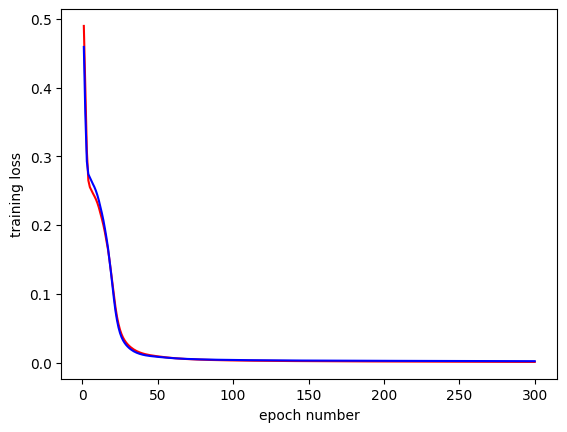

In [71]:
import matplotlib.pyplot as plt
### plot the training loss (y-axis) vs epoch number (x-axis)
### using the losses computed
plt.plot(range(1,num_epochs+1), train_losses, color = 'red')
plt.plot(range(1,num_epochs+1), val_losses, color = 'blue')
plt.xlabel("epoch number")
plt.ylabel("training loss")

Test network

In [79]:
hist_array = []
out_array = []
err1 = 0
err2 = 0
err3 = 0
tot = 0
count = 0
with torch.no_grad():
    for data in test_loader:
        # retrieve X and y for this batch, from data, and 
        # move it to the device you are using (probably the GPU)
        X = data[0].to(device)
        y = data[1].to(device)

        # raw output of network for X
        output = net(X)

        a = torch.add(torch.mul(output[0], tstd.to(device)), tmean.to(device))
        b = torch.add(torch.mul(y[0], tstd.to(device)), tmean.to(device))

        print("###################################################")
        print(a)
        print(b)
        # print(output[0])
        # print(y[0])
        print("###################################################")

        hist_array.append(a.cpu().numpy() - b.cpu().numpy())
        out_array.append(a.cpu().numpy())
        
        # let the maximum index be our predicted class
        # _, yh = torch.max(output, 1) 

        # tot will 10,000 at the end, total number of test data
        tot += y.size(0)

        ## add to err number of missclassification, i.e. number of indices that 
        ## yh and y are not equal
        ## note that y and yh are vectors of size = batch_size = (256 in our case)
        # err += (y != yh).sum()

        errors = output.sub(y).multiply(output.sub(y)).div(2).sum(axis=0)
        err1 += errors[0]
        err2 += errors[1]
        err3 += errors[2]
        count += 1

print(tot)
print(err1/count)
print(err2/count)
print(err3/count)

print('Accuracy of prediction on test (1): %5.2f%%' % (100-100 * err1 / tot))

print('Accuracy of prediction on test (2): %5.2f%%' % (100-100 * err2 / tot))

print('Accuracy of prediction on test (3): %5.2f%%' % (100-100 * err3 / tot))

###ASSERTS
# assert((100-100 * err / tot)>=98)
# assert(tot==10*1000)

###################################################
tensor([1.0029e+06, 1.0073e+00, 1.0055e+04], device='cuda:0',
       dtype=torch.float64)
tensor([1.0000e+06, 1.0000e+00, 1.0000e+04], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([2.5340e+06, 2.5323e+00, 2.5325e+04], device='cuda:0',
       dtype=torch.float64)
tensor([2.5000e+06, 2.5000e+00, 2.5000e+04], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([2.3922e+06, 2.3943e+00, 2.3902e+04], device='cuda:0',
       dtype=torch.float64)
tensor([2.5000e+06, 2.5000e+00, 2.5000e+04], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([2.0342e+06, 2.0396e+00, 2.0342e+04], device='cuda:0',
       dtype=torch.float64)
tensor

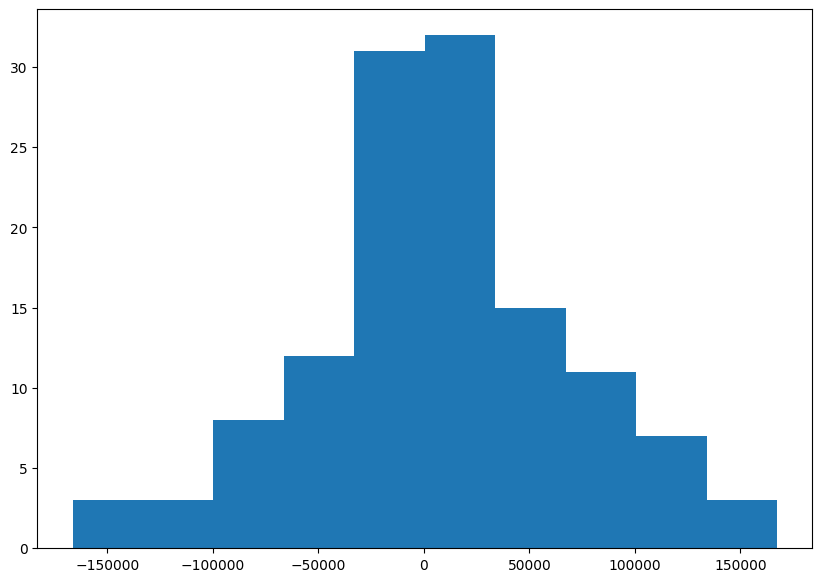

In [80]:
hist_array = np.array(hist_array)
a = hist_array[:, 0]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

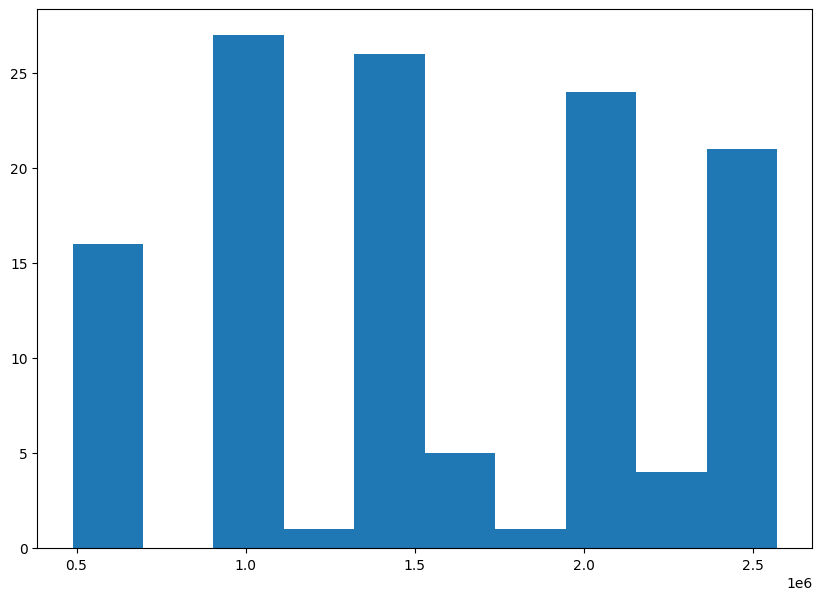

In [81]:
out_array = np.array(out_array)
a = out_array[:, 0]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

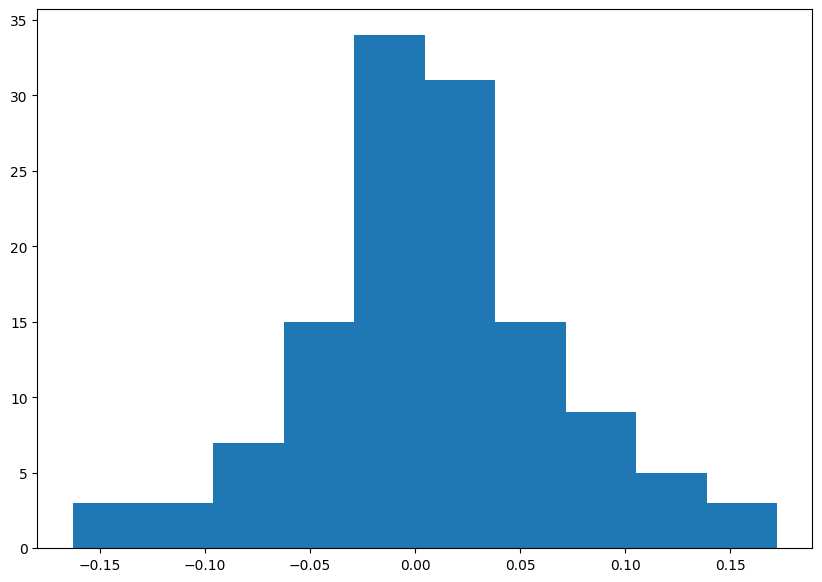

In [74]:
a = hist_array[:, 1]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

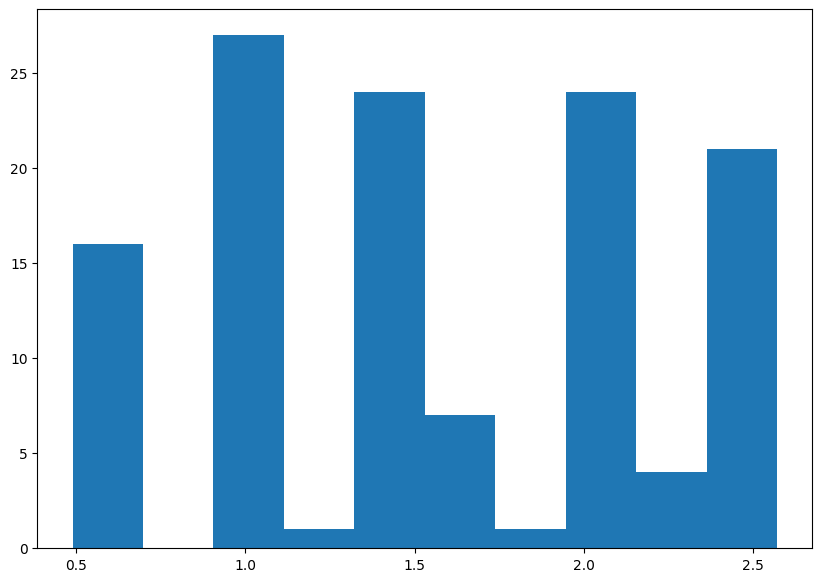

In [82]:
a = out_array[:, 1]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

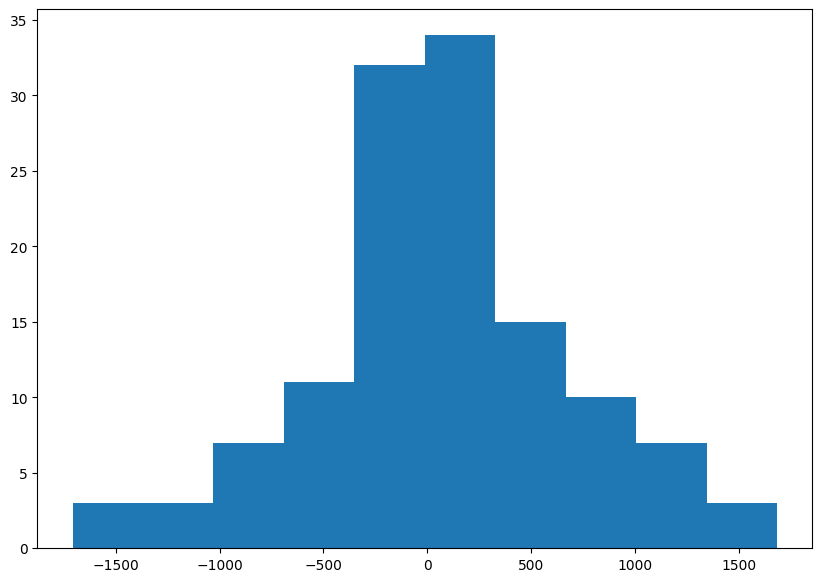

In [75]:
a = hist_array[:, 2]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

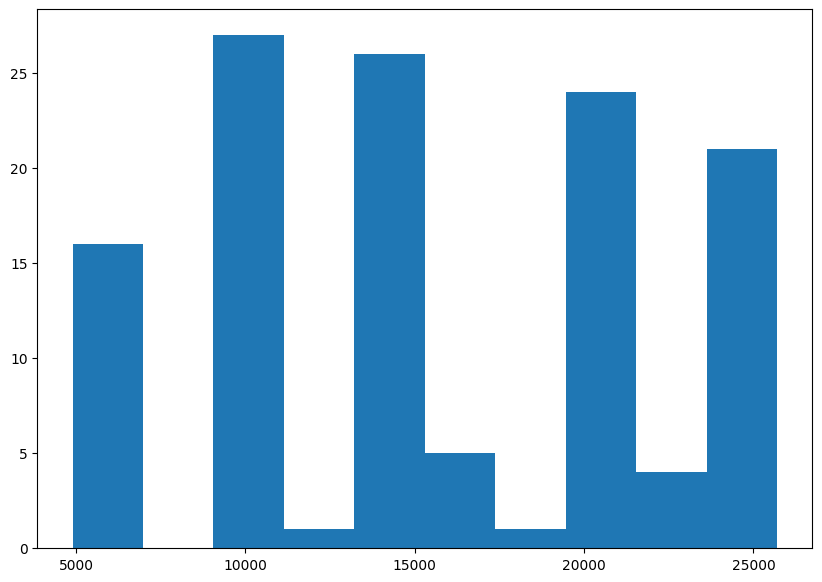

In [83]:
a = out_array[:, 2]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

In [76]:
# os.chdir('../HMEI2023-bxliu-models/')
# save_file = 'only_sigma.pt'
# torch.save(net.state_dict(), save_file)

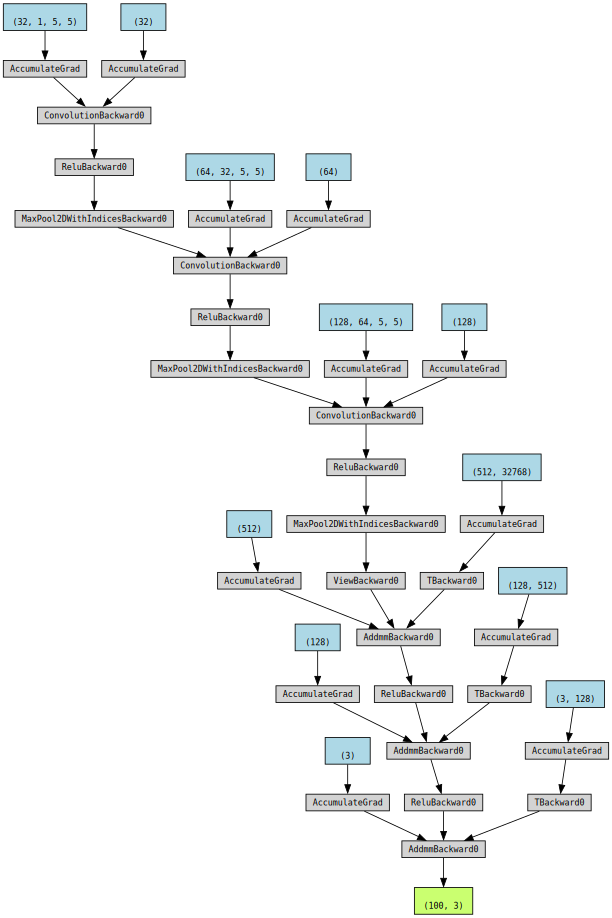

In [77]:
test_data = torch.rand(100,1,128,128)
test_net = ConvNet()
out = test_net.forward(test_data)
make_dot(out)  # ACT10

Next Steps:
custom loss function (later)
documentation (done)
validation (done-ish, needs going thru again with all the datasets probably)
more data
graph outputs not just loss (done)
outside training set for 5by400 and 10by200

